# Read & Clean Hiragana Dataset

## 1 - Import all required modules

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage.transform

from PIL import Image
from sklearn.model_selection import train_test_split
from utils.constants import HIRAGANA
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Init Plugin
Init Graph Optimizer
Init Kernel


## 2 - Declare the constants

In [2]:
BASE_PATH = './data/etl7'
UNPACK_STRING = '>H2sH6BI4H4B4x2016s4x'
FILES = ['ETL7LC_1', 'ETL7LC_2', 'ETL7SC_1', 'ETL7SC_2']
RECORDS_NB = [9600, 7200, 9600, 7200]
RECORD_LENGTH = 2052 # bytes
WIDTH = 64
HEIGHT = 63
COLUMNS_LABELS = ['phonetic', 'hiragana','image_bytes']

## 3 - Unpack Data

In [3]:
records_list = []

for filename in FILES:
    file_index = FILES.index(filename)
    records_nb = RECORDS_NB[file_index]
    count = 0
    f = open(f'{BASE_PATH}/{filename}', 'rb')

    while count <= records_nb:
        record_string = f.read(RECORD_LENGTH)

        if len(record_string) < RECORD_LENGTH:
            break

        record = struct.unpack(UNPACK_STRING, record_string)

        phonetic = record[1].decode('ascii')
        hiragana = HIRAGANA[phonetic]

        record_data = [phonetic, hiragana,record[18]]

        records_list.append(record_data)
        count+=1

    f.close()

df = pd.DataFrame(records_list, columns=COLUMNS_LABELS)

print(f'{len(df)}/{sum(RECORDS_NB)} records loaded')
print(f'{df.phonetic.nunique()} unique characters')
df.head()

33600/33600 records loaded
48 unique characters


,phonetic,hiragana,image_bytes
0,A,あ,"b'2#3\x133#""""!""""""2#\x12""3""23\x122#""\x13\x123""3..."
1,A,あ,"b'3334332""#3""2C""#2#""!3""2#""""""""""23C233CC33C33322..."
2,A,あ,"b'32333333#22""3""2""#2""#""2#2""#33#3332233#233""22\..."
3,A,あ,"b'C4B33332232#33##3""###3""2#3243333D3C433#2232$..."
4,A,あ,"b'2223""2!""""""!""#""""""22""""\x12!""!!""#\x12""""23312#""""..."


## 4 - Convert Byte to Image and Image to Numpy Array

In [4]:
def bytes_to_image(img_bytes):
    # Convert bytes to image
    return Image.frombytes('F', (WIDTH, HEIGHT), img_bytes, 'bit', 4).convert('P')

bytes_to_arr = lambda x: np.array(bytes_to_image(x['image_bytes']), dtype='float32')

df['image_matrix'] = df.apply(bytes_to_arr, axis=1)
df = df.drop(columns=['image_bytes'])

df.head()

,phonetic,hiragana,image_matrix
0,A,あ,"[[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0,..."
1,A,あ,"[[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0,..."
2,A,あ,"[[3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0,..."
3,A,あ,"[[4.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 3.0,..."
4,A,あ,"[[3.0, 2.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0,..."


## 5 - Clean Image Noise
- Check what looks image with noise
- Check the intensity distribution of the pixels
- Clean the image
- Check what looks image without noise
- Check the intensity distribution of the cleaned pixels

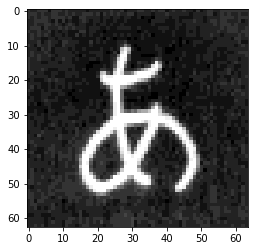

In [5]:
plt.imshow(df['image_matrix'][0], cmap='gray', interpolation='nearest')
plt.show()

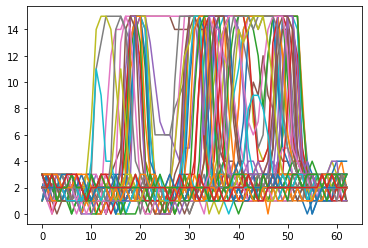

In [6]:
plt.plot(df['image_matrix'][0])
plt.show()

In [ ]:
def remove_noise(bytes_matrix, threshold=5):
    cleaned_matrix = []
    for row in bytes_matrix:
        cleaned_row = [0 if px <= threshold else px for px in row]
        cleaned_matrix.append(np.array(cleaned_row))
    return np.array(cleaned_matrix)

clean_noise = lambda x: remove_noise(x['image_matrix'], threshold=6)

df['image_matrix'] = df.apply(clean_noise, axis=1)

df.head()

In [ ]:
plt.imshow(df['image_matrix'][0], cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
plt.plot(df['image_matrix'][0])
plt.show()

# 6 - Visualize the Data

In [ ]:
n_rows = 8
n_cols = 6
plt.rc('axes', unicode_minus=False)
_, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 24))

size = len(HIRAGANA) / 2
hiragana_list = list(HIRAGANA.values())

for index, value in enumerate(hiragana_list):
    x = int(index / n_cols)
    y = index % n_cols
    ax = axes[x][y]
    phonetic, _, image_matrix = df[df['hiragana'] == value].values[0]
    ax.imshow(image_matrix, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(phonetic)
    ax.axis('off')

plt.savefig('hiragana_data_gallery.jpg')
plt.show()

# 7 - Prepare Training Set

### 7.1 - Prepare Labels Dataset

In [ ]:
labels = []
phonetics_list = df['phonetic']
unique_labels = phonetics_list.unique()

# Transform labels to number for categorical classification
categorical_labels = keras.utils.to_categorical(np.arange(0, num_classes, 1), num_classes)

for p in phonetics_list:
    label, = np.where(p == unique_labels)[0]
    labels.append(label)
    
labels = np.asarray(labels)
labels.shape

### 7.2 - Prepare Image Dataset

In [ ]:
data = []
TARGET_SIZE=(48,48)

for image in df['image_matrix']:
    resized_image = skimage.transform.resize(image, TARGET_SIZE)
    data.append(resized_image)
    

data = np.array(data, dtype='float32')
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)
data.shape

In [ ]:
data[0].shape

### 7.3 - Split into Train & Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.4)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

### 7.4 - Rescale & Batch Data

In [ ]:
data_generator = ImageDataGenerator(rescale=1.0/255.0)

train_set = data_generator.flow(X_train, y=y_train, batch_size=64)
test_set = data_generator.flow(X_test, y=y_test, batch_size=64)

## 8 - Create CNN Model

In [ ]:
input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = Sequential([
    
    Conv2D(32, (3,3), 
           activation='relu',
           input_shape=input_shape,
           padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(48, activation="softmax")
])

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, 
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy']
             )

model.summary()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

history = model.fit(train_set, epochs=20, verbose=1)

## 9 - Analyze model training

### 1 - Plot Accuracy

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.xticks(np.arange(0, 20), np.arange(1, 21))
plt.show()

### 2 - Plot Loss

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.xticks(np.arange(0, 20), np.arange(1, 21))
plt.show()

## Evaluate model

In [ ]:
score = model.evaluate(test_it)

print(f'The prediction rate of the model is {format(score[1]*100,".2f")}% on {len(test_it)*len(test_it[0][0])} test images.')